In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import keras
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
(keras.__version__, tf.__version__)

Using TensorFlow backend.


('2.2.2', '1.10.0')

In [3]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv")[:400001]
df.head()

,timestamp,open,high,low,close,volume
0,2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
1,2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2,2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
3,2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
4,2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [4]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

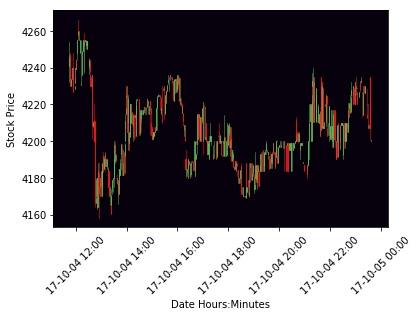

In [5]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, facecolor='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

In [6]:
# Add a minute moving average over period
def add_moving_avg(df, period=30):
    #df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)
    df[f"{period}_ma"] = df.close.rolling(period).mean()
#add_moving_avg(df)
df.tail()

,timestamp,open,high,low,close,volume
399996,2017-10-04 23:38:00,4200.0,4200.777778,4200.0,4200.777778,0.936470
399997,2017-10-04 23:39:00,4206.0,4206.000000,4206.0,4206.000000,0.005956
399998,2017-10-04 23:40:00,4200.0,4200.000000,4200.0,4200.000000,0.288765
399999,2017-10-04 23:41:00,4206.0,4206.000000,4206.0,4206.000000,0.020000
400000,2017-10-04 23:42:00,4206.0,4206.000000,4206.0,4206.000000,0.098507


In [7]:
float_data = df.iloc[:, 1:].values
float_data[100000:100010], 

(array([[ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.],
        [ 1240.,  1240.,  1240.,  1240.,     0.]]),)

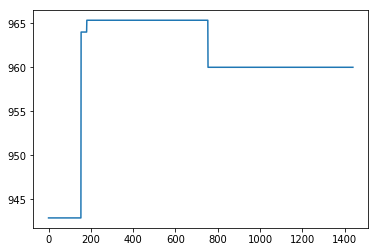

In [8]:
plt.plot(range(1440), float_data[:1440,3])
plt.show()

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              target_field=1, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_field]
        yield samples, targets

In [11]:
target_idx = 3  # Field in float_data that we're attempting to predict
lookback = 240 #1440  # How many timesteps back should our input data go.
step = 1 #6  # The period, in timesteps, at which we sample data.
delay = 1 #144  # How many timesteps in the future should our target be.
batch_size = 128  # The number of samples per batch.

train_gen = generator(float_data,
                      target_field=target_idx,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    target_field=target_idx,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     target_field=target_idx,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.025080281195


In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 25s 51ms/step - loss: 0.6601 - val_loss: 0.9157
Epoch 2/20
500/500 [==============================] - 26s 51ms/step - loss: 0.1402 - val_loss: 0.4940ETA: 2s - loss: 0.1 - ETA: 1s - l - ETA: 1 - ETA: 0s - loss: 0.
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0821 - val_loss: 0.4618
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0636 - val_loss: 0.3063
Epoch 5/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0552 - val_loss: 0.3690
Epoch 6/20
500/500 [==============================] - 26s 52ms/step - loss: 0.0485 - val_loss: 0.2787
Epoch 7/20
500/500 [==============================] - 28s 55ms/step - loss: 0.0446 - val_loss: 0.1930
Epoch 8/20
500/500 [==============================] - 22s 44ms/step - loss: 0.0413 - val_loss: 0.5066
Epoch 9/20
500/500 [==============================] - 21s 43ms/step - loss: 0.0389 - val_loss: 0.3398
Epoch 10/20
500/500

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111437). Check your callbacks.
  % delta_t_median)
/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108334). Check your callbacks.
  % delta_t_median)


500/500 [==============================] - 22s 45ms/step - loss: 0.0329 - val_loss: 0.2388 ETA: 3s - loss:
Epoch 16/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0321 - val_loss: 0.1732
Epoch 17/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0321 - val_loss: 0.3077
Epoch 18/20
500/500 [==============================] - 24s 47ms/step - loss: 0.0319 - val_loss: 0.2548
Epoch 19/20
500/500 [==============================] - 26s 52ms/step - loss: 0.0315 - val_loss: 0.3733
Epoch 20/20
500/500 [==============================] - 24s 49ms/step - loss: 0.0314 - val_loss: 0.2682


/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105232). Check your callbacks.
  % delta_t_median)


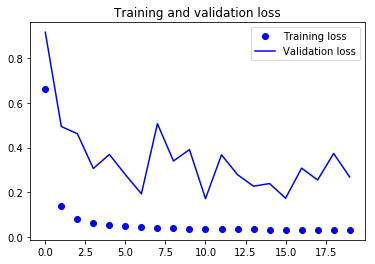

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
117/500 [======>.......................] - ETA: 1:46 - loss: 0.0720

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()